<h2> 6. Bayes Classification </h2>

This notebook has the code for the charts in Chapter 6


### Setup

In [1]:
PROJECT=!gcloud config get-value project
PROJECT=PROJECT[0]

In [2]:
import os
BUCKET = PROJECT + '-dsongcp' # REPLACE WITH YOUR BUCKET NAME if this won't work
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

os.environ['BUCKET'] = BUCKET

<h3> Exploration using BigQuery </h3>

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import google.cloud.bigquery as bigquery

bq = bigquery.Client()

In [4]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM dsongcp.flights_tzcorr
WHERE RAND() < 0.001 AND dep_delay > -20 AND dep_delay < 30 AND distance < 2000
"""
df = bq.query(sql).to_dataframe()

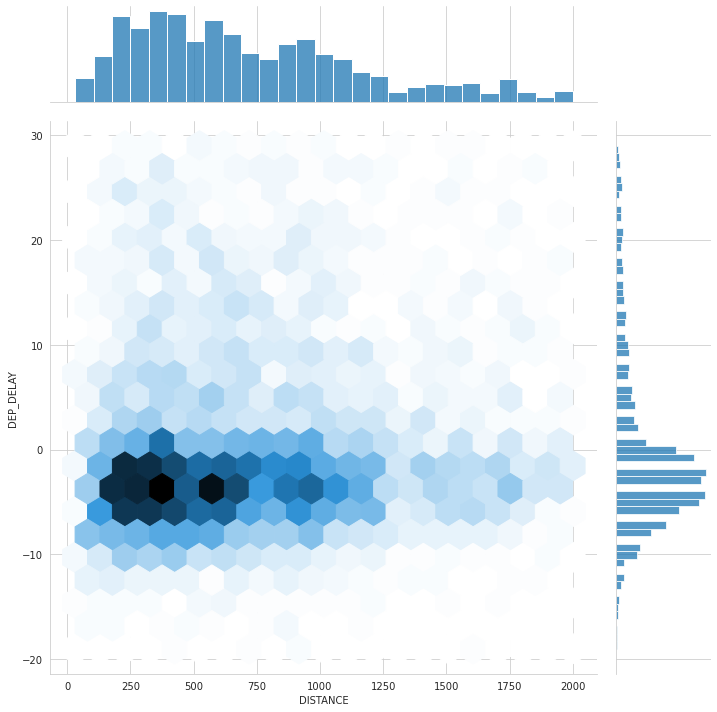

In [5]:
sns.set_style("whitegrid")
g = sns.jointplot(x=df['DISTANCE'], y=df['DEP_DELAY'], kind="hex", height=10, joint_kws={'gridsize':20})

<h3> Set up views in Spark SQL </h3>

Start a Spark Session if necessary and get a handle to it.

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bayes classification using Spark") \
    .getOrCreate()
print(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Create a table definition (this is done lazily; the files won't be read until we issue a query):

In [7]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # 1/30th
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)  # FULL
flights = spark.read.json(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

In [8]:
# Note that distance is STRING
print(flights.schema)

StructType(List(StructField(ARR_AIRPORT_LAT,DoubleType,true),StructField(ARR_AIRPORT_LON,DoubleType,true),StructField(ARR_AIRPORT_TZOFFSET,DoubleType,true),StructField(ARR_DELAY,DoubleType,true),StructField(ARR_TIME,StringType,true),StructField(CANCELLED,BooleanType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_AIRPORT_LAT,DoubleType,true),StructField(DEP_AIRPORT_LON,DoubleType,true),StructField(DEP_AIRPORT_TZOFFSET,DoubleType,true),StructField(DEP_DELAY,DoubleType,true),StructField(DEP_TIME,StringType,true),StructField(DEST,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DISTANCE,StringType,true),StructField(DIVERTED,BooleanType,true),StructField(FL_DATE,StringType,true),StructField(ORIGIN,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(TAXI_IN,DoubleType,true),StructField(TAXI_OUT,DoubleType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(WHEELS_OFF,

Example query over the view:

In [9]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND CAST(distance AS FLOAT) < 2000')
results.show()

+--------+
|count(1)|
+--------+
|   59665|
+--------+



<h2> Restrict to train days </h2>

Let's create a CSV file of the training days

In [10]:
sql = """
SELECT *
FROM dsongcp.trainday
"""
df = bq.query(sql).to_dataframe()
df.to_csv('trainday.csv', index=False)

In [11]:
!head -3 trainday.csv

FL_DATE,is_train_day
2015-01-01,True
2015-01-02,False


In [12]:
%%bash
gsutil cp trainday.csv gs://${BUCKET}/flights/trainday.csv

Copying file://trainday.csv [Content-Type=text/csv]...
/ [1 files][  5.8 KiB/  5.8 KiB]                                                
Operation completed over 1 objects/5.8 KiB.                                      


Create dataframe of traindays.

In [13]:
from pyspark.sql.types import StructType, StructField, StringType, BooleanType
schema = StructType([
    StructField('FL_DATE', StringType(), True),
    StructField('is_train_day', BooleanType(), True)
])
traindays = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

traindays.createOrReplaceTempView('traindays')

In [14]:
results = spark.sql('SELECT * FROM traindays')
results.head(5)

[Row(FL_DATE='2015-01-01', is_train_day=True),
 Row(FL_DATE='2015-01-02', is_train_day=False),
 Row(FL_DATE='2015-01-03', is_train_day=False),
 Row(FL_DATE='2015-01-04', is_train_day=True),
 Row(FL_DATE='2015-01-05', is_train_day=True)]

In [15]:
statement = """
SELECT
  f.FL_DATE AS date,
  CAST(distance AS FLOAT) AS distance,
  dep_delay,
  IF(arr_delay < 15, 1, 0) AS ontime
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day AND
  f.dep_delay IS NOT NULL
ORDER BY
  f.dep_delay DESC
"""
flights = spark.sql(statement)

<h3> Hexbin plot </h3>

Create a hexbin plot using Spark (repeat of what we did in BigQuery, except that we are now restricting to train days only).

In [16]:
df = flights[(flights['distance'] < 2000) & (flights['dep_delay'] > -20) & (flights['dep_delay'] < 30)]
df.describe().show()

+-------+----------+------------------+------------------+------------------+
|summary|      date|          distance|         dep_delay|            ontime|
+-------+----------+------------------+------------------+------------------+
|  count|     38337|             38337|             38337|             38337|
|   mean|      null| 809.5545817356601|0.4259070871481858|0.9186425646242533|
| stddev|      null|458.63090955225306|  8.10578630526965|0.2733868187142124|
|    min|2015-01-01|             130.0|             -19.0|                 0|
|    max|2015-12-30|            1972.0|              29.0|                 1|
+-------+----------+------------------+------------------+------------------+



In [17]:
df.head(5)

[Row(date='2015-12-22', distance=488.0, dep_delay=29.0, ontime=0),
 Row(date='2015-02-21', distance=446.0, dep_delay=29.0, ontime=0),
 Row(date='2015-01-11', distance=446.0, dep_delay=29.0, ontime=0),
 Row(date='2015-04-17', distance=488.0, dep_delay=29.0, ontime=0),
 Row(date='2015-05-04', distance=628.0, dep_delay=29.0, ontime=0)]

Sample the dataframe so that it fits into memory (not a problem in development, but will be on full dataset); then plot it.

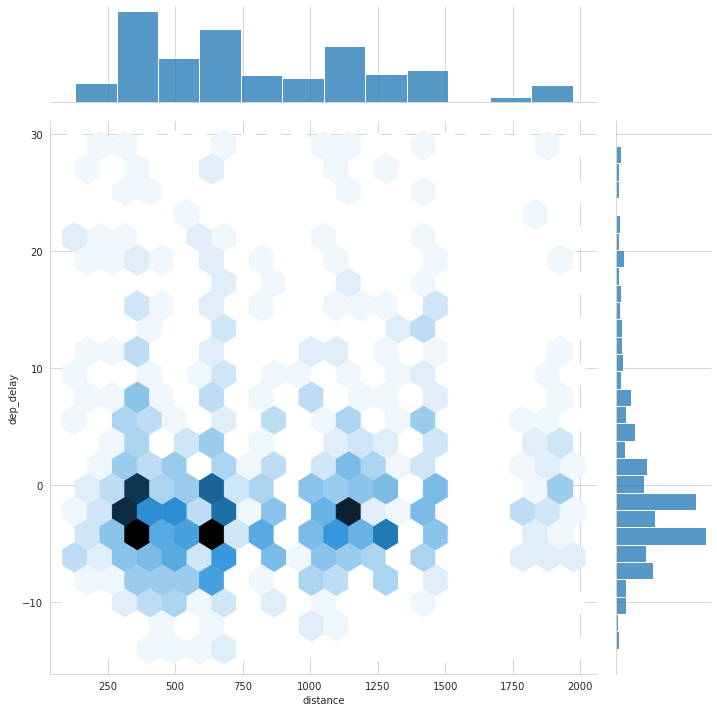

In [18]:
pdf = df.sample(False, 0.02, 20).toPandas()  # to 100,000 rows approx on complete dataset
g = sns.jointplot(x=pdf['distance'], y=pdf['dep_delay'], kind="hex", height=10, joint_kws={'gridsize':20})

<h3> Quantization </h3>

Now find the quantiles

In [19]:
distthresh = flights.approxQuantile('distance', list(np.arange(0, 1.0, 0.2)), 0.02)
distthresh

[130.0, 370.0, 621.0, 1009.0, 1276.0]

In [21]:
delaythresh = flights.approxQuantile('dep_delay', list(np.arange(0, 1.0, 0.2)), 0.05)
delaythresh

[-22.0, -5.0, -3.0, 0.0, 10.0]

## Do Bayes in each bin

In [23]:
import pyspark.sql.functions as F
import pandas as pd

df = pd.DataFrame(columns=['dist_thresh', 'delay_thresh', 'frac_ontime'])
for m in range(0, 2): # len(distthresh)-1):
    for n in range(0, len(delaythresh)-1):
        bdf = flights[(flights['distance'] >= distthresh[m])
             & (flights['distance'] < distthresh[m+1])
             & (flights['dep_delay'] >= delaythresh[n])
             & (flights['dep_delay'] < delaythresh[n+1])]
        ontime_frac = bdf.agg(F.sum('ontime')).collect()[0][0] / bdf.agg(F.count('ontime')).collect()[0][0]
        print (m, n, ontime_frac)
        df = df.append({
            'dist_thresh': distthresh[m], 
            'delay_thresh': delaythresh[n],
            'frac_ontime': ontime_frac
        }, ignore_index=True)

0 0 0.9853403141361257
0 1 0.9847756410256411
0 2 0.9753028890959925
0 3 0.946509009009009
1 0 0.9721913236929922
1 1 0.9650856389986825
1 2 0.9711299153807864
1 3 0.9301014656144306


We are nowhere close to the 70% threshold ... let's fine tune the delay thresh around the decision boundary.
Which we know is on the order of 15 minutes.

In [24]:
delaythresh = range(10, 20)

df = pd.DataFrame(columns=['dist_thresh', 'delay_thresh', 'frac_ontime'])
for m in range(0, len(distthresh)-1):
    for n in range(0, len(delaythresh)-1):
        bdf = flights[(flights['distance'] >= distthresh[m])
             & (flights['distance'] < distthresh[m+1])
             & (flights['dep_delay'] >= delaythresh[n])
             & (flights['dep_delay'] < delaythresh[n+1])]
        ontime_frac = bdf.agg(F.sum('ontime')).collect()[0][0] / bdf.agg(F.count('ontime')).collect()[0][0]
        print (m, n, ontime_frac)
        df = df.append({
            'dist_thresh': distthresh[m], 
            'delay_thresh': delaythresh[n],
            'frac_ontime': ontime_frac
        }, ignore_index=True)

0 0 0.8735632183908046


0 1 0.8823529411764706
0 2 0.8833333333333333
0 3 0.8529411764705882
0 4 0.765625
0 5 0.7678571428571429


0 6 0.6206896551724138
0 7 0.75
0 8 0.5714285714285714
1 0 0.8823529411764706
1 1 0.8275862068965517
1 2 0.7922077922077922


1 3 0.7037037037037037
1 4 0.6333333333333333
1 5 0.7611940298507462
1 6 0.6101694915254238
1 7 0.5471698113207547
1 8 0.5789473684210527


2 0 0.8556701030927835
2 1 0.8865979381443299
2 2 0.8297872340425532
2 3 0.8620689655172413
2 4 0.84
2 5 0.7352941176470589
2 6 0.75
2 7 0.6981132075471698
2 8 0.5970149253731343
3 0 0.921875
3 1 0.7941176470588235
3 2 0.8484848484848485
3 3 0.7647058823529411
3 4 0.7755102040816326
3 5 0.7777777777777778
3 6 0.6956521739130435
3 7 0.625
3 8 0.5555555555555556


In [25]:
df['score'] = abs(df['frac_ontime'] - 0.7)
bayes = df.sort_values(['score']).groupby('dist_thresh').head(1).sort_values('dist_thresh')
bayes

,dist_thresh,delay_thresh,frac_ontime,score
7,130.0,17.0,0.750000,0.050000
12,370.0,13.0,0.703704,0.003704
25,621.0,17.0,0.698113,0.001887
33,1009.0,16.0,0.695652,0.004348


In [27]:
bayes.to_csv('bayes.csv', index=False)
!cat bayes.csv

dist_thresh,delay_thresh,frac_ontime,score
130.0,17.0,0.75,0.050000000000000044
370.0,13.0,0.7037037037037037,0.0037037037037037646
621.0,17.0,0.6981132075471698,0.0018867924528301883
1009.0,16.0,0.6956521739130435,0.004347826086956497


In [47]:
bayes[ bayes['dist_thresh'] == distthresh[1] ]['delay_thresh'].values[0]

13.0

## Evaluate model

Use the decision threshold to see how well model does on held-out flights in the first bucket

In [65]:
m = 1
statement = """
SELECT
  '{0:.0f}-{1:.0f} miles' AS bin,
  ROUND(SUM(IF(dep_delay < {2:f} AND arr_delay < 15, 1, 0))/COUNT(*), 2) AS correct_nocancel,
  ROUND(SUM(IF(dep_delay >= {2:f} AND arr_delay < 15, 1, 0))/COUNT(*), 2) AS false_positive,
  ROUND(SUM(IF(dep_delay < {2:f} AND arr_delay >= 15, 1, 0))/COUNT(*), 2) AS false_negative,
  ROUND(SUM(IF(dep_delay >= {2:f} AND arr_delay >= 15, 1, 0))/COUNT(*), 2) AS correct_cancel,
  COUNT(*) AS total_flights
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.distance >= {0:f} AND f.distance < {1:f}
""".format( distthresh[m], distthresh[m+1], bayes[ bayes['dist_thresh'] == distthresh[m] ]['delay_thresh'].values[0] )
print(statement)
eval_flights = spark.sql(statement)
eval_flights.show()


SELECT
  '370-621 miles' AS bin,
  ROUND(SUM(IF(dep_delay < 13.000000 AND arr_delay < 15, 1, 0))/COUNT(*), 2) AS correct_nocancel,
  ROUND(SUM(IF(dep_delay >= 13.000000 AND arr_delay < 15, 1, 0))/COUNT(*), 2) AS false_positive,
  ROUND(SUM(IF(dep_delay < 13.000000 AND arr_delay >= 15, 1, 0))/COUNT(*), 2) AS false_negative,
  ROUND(SUM(IF(dep_delay >= 13.000000 AND arr_delay >= 15, 1, 0))/COUNT(*), 2) AS correct_cancel,
  COUNT(*) AS total_flights
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.distance >= 370.000000 AND f.distance < 621.000000

+-------------+----------------+--------------+--------------+--------------+-------------+
|          bin|correct_nocancel|false_positive|false_negative|correct_cancel|total_flights|
+-------------+----------------+--------------+--------------+--------------+-------------+
|370-621 miles|            0.77|          0.03|          0.03|          0.15|         3626|
+-------------+-------------

In [66]:
for m in range(0, len(distthresh)-1):
    statement = """
SELECT
  '{0:.0f}-{1:.0f} miles' AS bin,
  ROUND(SUM(IF(dep_delay < {2:f} AND arr_delay < 15, 1, 0))/COUNT(*), 2) AS correct_nocancel,
  ROUND(SUM(IF(dep_delay >= {2:f} AND arr_delay < 15, 1, 0))/COUNT(*), 2) AS false_positive,
  ROUND(SUM(IF(dep_delay < {2:f} AND arr_delay >= 15, 1, 0))/COUNT(*), 2) AS false_negative,
  ROUND(SUM(IF(dep_delay >= {2:f} AND arr_delay >= 15, 1, 0))/COUNT(*), 2) AS correct_cancel,
  COUNT(*) AS total_flights
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.distance >= {0:f} AND f.distance < {1:f}
""".format( distthresh[m], distthresh[m+1], bayes[ bayes['dist_thresh'] == distthresh[m] ]['delay_thresh'].values[0] )
    eval_flights = spark.sql(statement)
    eval_flights.show()

+-------------+----------------+--------------+--------------+--------------+-------------+
|          bin|correct_nocancel|false_positive|false_negative|correct_cancel|total_flights|
+-------------+----------------+--------------+--------------+--------------+-------------+
|130-370 miles|            0.82|          0.02|          0.02|          0.13|         3131|
+-------------+----------------+--------------+--------------+--------------+-------------+

+-------------+----------------+--------------+--------------+--------------+-------------+
|          bin|correct_nocancel|false_positive|false_negative|correct_cancel|total_flights|
+-------------+----------------+--------------+--------------+--------------+-------------+
|370-621 miles|            0.77|          0.03|          0.03|          0.15|         3626|
+-------------+----------------+--------------+--------------+--------------+-------------+

+--------------+----------------+--------------+--------------+--------------+

<h2> Repeat, but on full dataset </h2>

You can launch the above processing on the full dataset from within JupyterLab if you want the statistics and graphs updated. I didn't, though, because this is not what I would have really done. Instead, 
I would have created a standalone Python script and submitted it to the cluster -- there is no need to put JupyterLab in the middle of a production process. We'll submit a standalone Pig program to the cluster in the next section.

Steps:
<ol>
<li> Change the input variable to process all-flights-* </li>
<li> Increase cluster size (bash increase_cluster.sh from CloudShell) </li>
<li> Clear all cells from this notebook </li>
<li> Run all cells </li>
<li> Decrease cluster size (bash decrease_cluster.sh from CloudShell) </li>
</ol>


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.